# Toy Data: 8-Modes Mixture Model

## Introduction

This notebook is supposed to demonstrate how to use FrEIA to create reversible architectures.

We will use the toy data from the paper in this example.

In [1]:
%matplotlib notebook
from time import time

import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom

import data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Setting up the data

We generate the data by sampling from a Gaussian mixture distribution with 8 labeled modes. The dataset will contain $2^{20}$ samples, $10000$ of which we will use for testing purposes.

You can see a plot of the test data below.

In the forward process our model is supposed to predict the label (or in this case, color) of a sample based on its position in $\mathbb{R}^2$. In the reverse direction the model should allow us to sample from the mixture component given by a label.

<IPython.core.display.Javascript object>


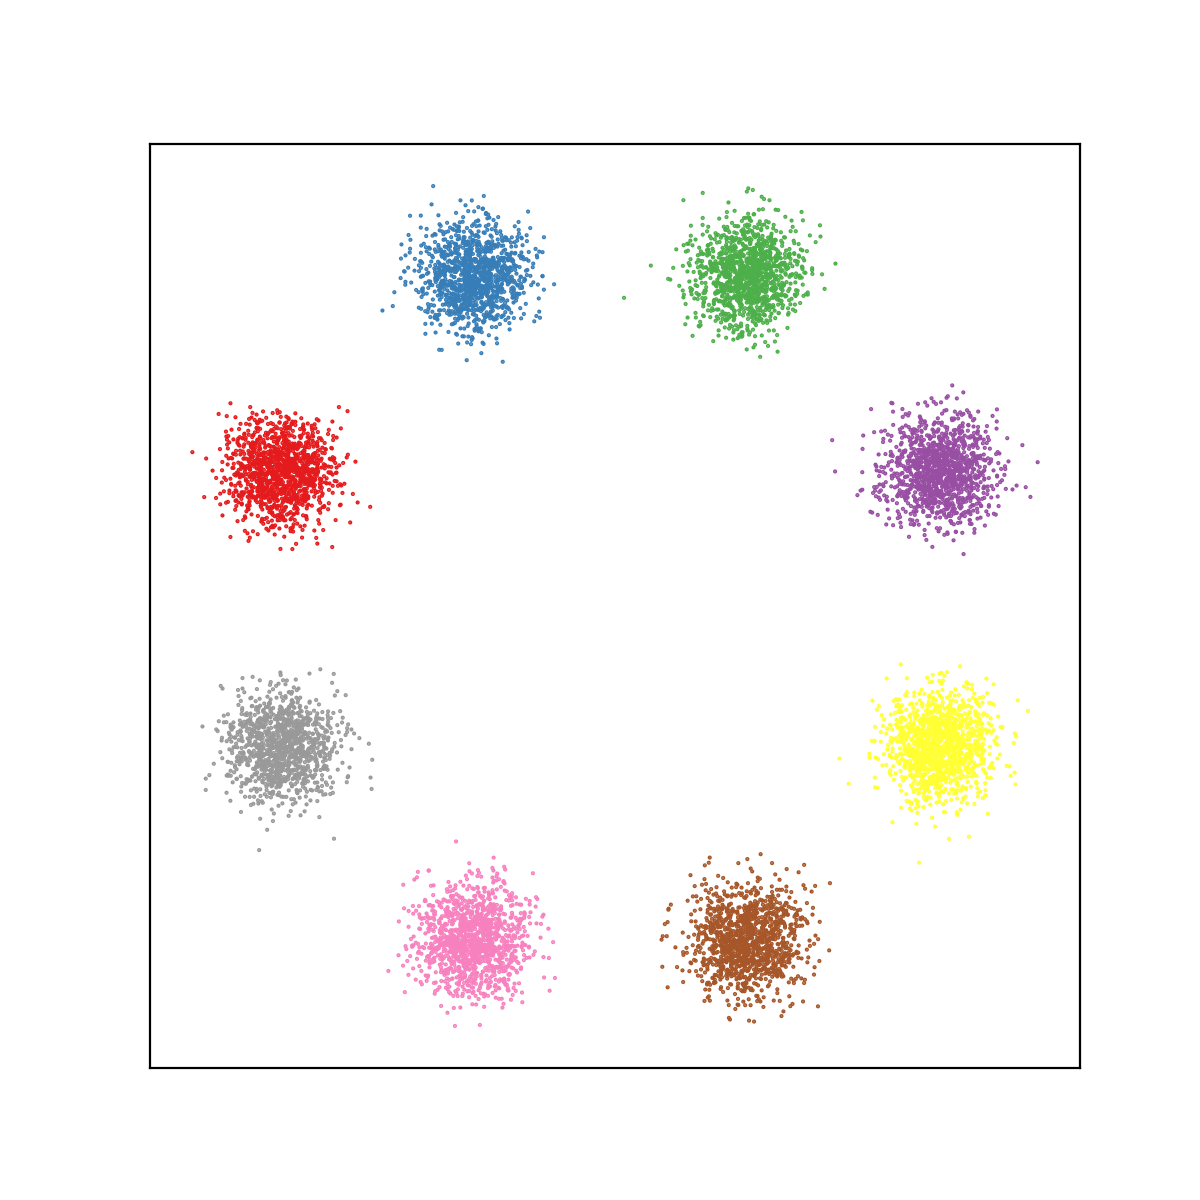

In [2]:
batch_size = 1600
test_split = 10000

pos, labels = data.generate(
    labels='all',
    tot_dataset_size=2**20
)
c = np.where(labels[:test_split])[1]
plt.figure(figsize=(6, 6))
plt.scatter(pos[:test_split, 0], pos[:test_split, 1], c=c, cmap='Set1', s=0.25)
plt.xticks([])
plt.yticks([])
plt.show()

## Setting up the model

Our model consists of three invertible blocks using multiplicative coupling layers and 3-layer fully connected sub-networks for $s_i$ and $t_i$. The input is encoded in 2 dimensions. The latent dimension $z$ is set to 2 and concatenated with the predicted labels $y$ encoded as a 8-dimensional one-hot vector. In- and output are zero-padded to 16 dimensions.

In [3]:
ndim_tot = 16
ndim_x = 2
ndim_y = 8
ndim_z = 2

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                         nn.Linear(512,  c_out))

nodes = [InputNode(ndim_tot, name='input')]

for k in range(8):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':2.0},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))

nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False)

## Training the model

We will train our model using 3 losses. In the forward direction we apply a MSE loss to the assigned label and a distributional loss to the latent variable $z$.
We make use of the reversability of our model and apply a third loss, that matches the distribution of samples from our dataset to the distribution of backward predictions of our model.
You can find more information on the losses in the [paper](https://arxiv.org/abs/1808.04730).


In [4]:
# Training parameters
n_epochs = 50
n_its_per_epoch = 8
batch_size = 1600

lr = 1e-3
l2_reg = 2e-5

y_noise_scale = 1e-1
zeros_noise_scale = 5e-2

# relative weighting of losses:
lambd_predict = 3.
lambd_latent = 300.
lambd_rev = 400.

pad_x = torch.zeros(batch_size, ndim_tot - ndim_x)
pad_yz = torch.zeros(batch_size, ndim_tot - ndim_y - ndim_z)

trainable_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, lr=lr, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=l2_reg)


def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for a in [0.05, 0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1

    return torch.mean(XX + YY - 2.*XY)


def fit(input, target):
    return torch.mean((input - target)**2)

loss_backward = MMD_multiscale
loss_latent = MMD_multiscale
loss_fit = fit

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos[:test_split], labels[:test_split]),
    batch_size=batch_size, shuffle=True, drop_last=True)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos[test_split:], labels[test_split:]),
    batch_size=batch_size, shuffle=True, drop_last=True)

We can now define ou training method. Note how we simply used the model for forward training, zeroed the gradients and switch to backwards training simply by setting `rev=True`. Randomness in the samples generated by backwards prediction is achieved by drawing $z$ randomly from a 2-dimensional Normal distribution.

In [5]:
def train(i_epoch=0):
    model.train()

    l_tot = 0
    batch_idx = 0
    
    t_start = time()
    
    # If MMD on x-space is present from the start, the model can get stuck.
    # Instead, ramp it up exponetially.  
    loss_factor = min(1., 2. * 0.002**(1. - (float(i_epoch) / n_epochs)))

    for x, y in train_loader:
        batch_idx += 1
        if batch_idx > n_its_per_epoch:
            break

        x, y = x.to(device), y.to(device)
        
        y_clean = y.clone()
        pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                ndim_x, device=device)
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)

        y += y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device)

        x, y = (torch.cat((x, pad_x),  dim=1),
                torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz, y),
                          dim=1))
        

        optimizer.zero_grad()

        # Forward step:

        output = model(x)

        # Shorten output, and remove gradients wrt y, for latent loss
        y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

        l = lambd_predict * loss_fit(output[:, ndim_z:], y[:, ndim_z:])

        output_block_grad = torch.cat((output[:, :ndim_z],
                                       output[:, -ndim_y:].data), dim=1)

        l += lambd_latent * loss_latent(output_block_grad, y_short)
        l_tot += l.data.item()

        l.backward()

        # Backward step:
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
        y = y_clean + y_noise_scale * torch.randn(batch_size, ndim_y, device=device)

        orig_z_perturbed = (output.data[:, :ndim_z] + y_noise_scale *
                            torch.randn(batch_size, ndim_z, device=device))
        y_rev = torch.cat((orig_z_perturbed, pad_yz,
                           y), dim=1)
        y_rev_rand = torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz,
                                y), dim=1)
        
        output_rev = model(y_rev, rev=True)
        output_rev_rand = model(y_rev_rand, rev=True)

        l_rev = (
            lambd_rev
            * loss_factor
            * loss_backward(output_rev_rand[:, :ndim_x],
                            x[:, :ndim_x])
        )

        l_rev += lambd_predict * loss_fit(output_rev, x)
        
        l_tot += l_rev.data.item()
        l_rev.backward()

        for p in model.parameters():
            p.grad.data.clamp_(-15.00, 15.00)

        optimizer.step()

    return l_tot / batch_idx

We initialize our model parameters using normal distributions. The following loop over epochs plots label predictions and backwards predicted samples, so you can see the model getting better during training.

<IPython.core.display.Javascript object>


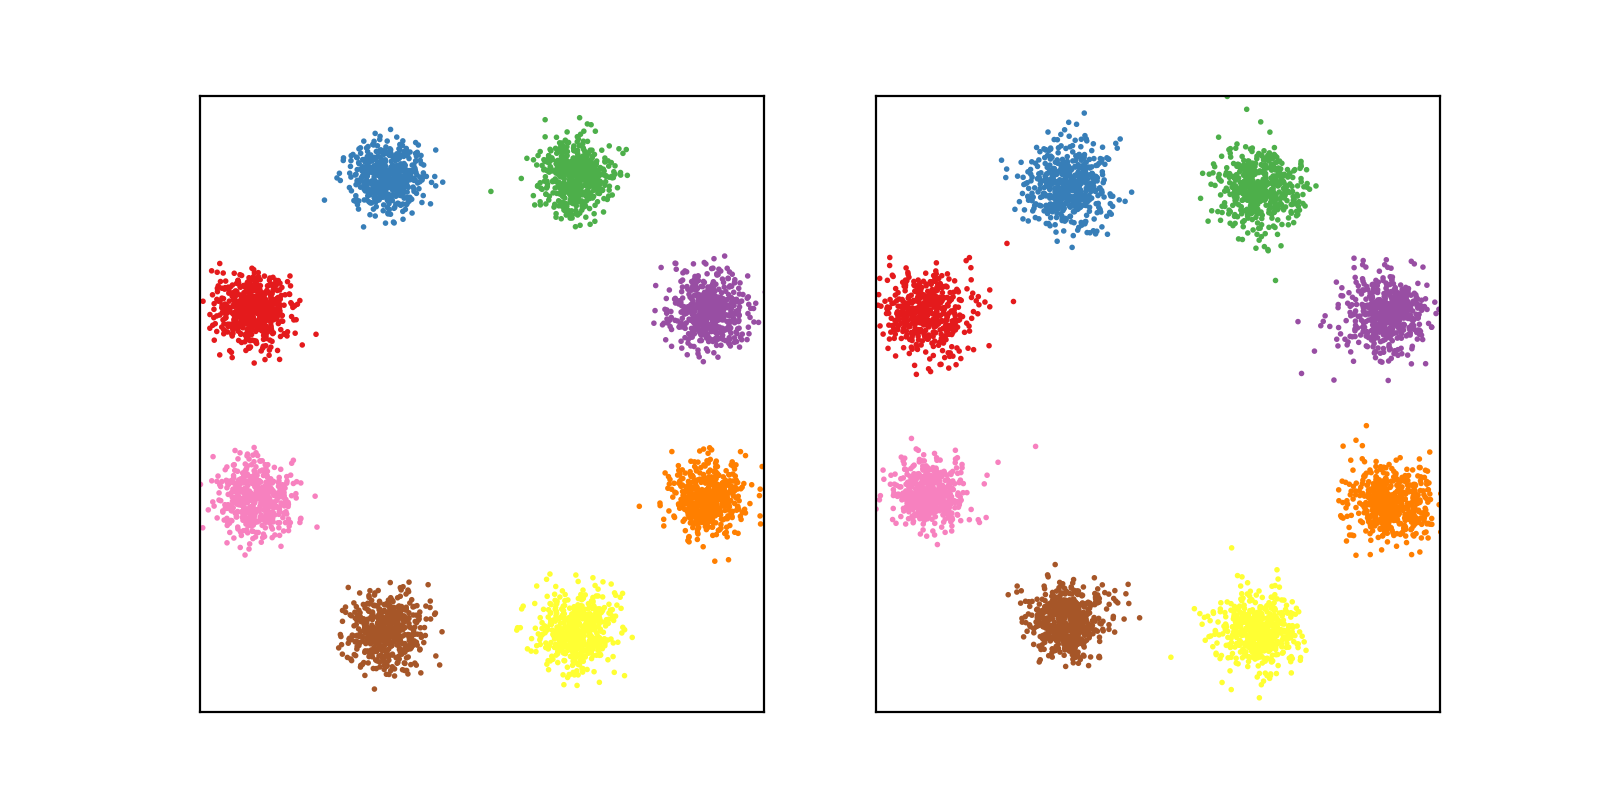

 90%|######################################7    | 45/50 [08:57<00:55, 11.17s/it]



Training took 9.14 minutes



In [6]:
for param in trainable_parameters:
    param.data = 0.05*torch.randn_like(param)
            
model.to(device)

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

N_samp = 4096

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
y_samps += y_noise_scale * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)

        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, -8:].argmax(dim=1)

        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3,3,-3,3])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3,3,-3,3])
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        
        fig.canvas.draw()


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")